In [55]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
register_matplotlib_converters()
from datetime import datetime
from datetime import timedelta
from meteostat import Point, Hourly

from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

Read in 1299 bike diff data

In [105]:
starts_ends_1299 = pd.read_csv("start_end_1299.csv")
starts_ends_1299['start_time_hour'] = pd.to_datetime(starts_ends_1299['start_time_hour'], format="%Y-%m-%d %H:%M:%S")
starts_ends_1299 = starts_ends_1299.set_index('start_time_hour') 
se1299 = starts_ends_1299[(starts_ends_1299.index.get_level_values(0) > '2021-12-31')]

### Create Variables from other stations

In [106]:
stations = pd.read_csv("stations.csv", 
                       dtype = {'start_station_id': str, 'end_station_id':str})

In [107]:
df = pd.DataFrame(
        {'start_time_hour': pd.date_range('2021-01-01', '2022-06-05', freq='1H', closed='left')})
df = df.tail(-1) #data starts from Jan 1st at 1am

In [108]:
stations['start_time'] = pd.to_datetime(stations['start_time'], format="%Y-%m-%d %H:%M:%S")
stations['end_time'] = pd.to_datetime(stations['end_time'], format="%Y-%m-%d %H:%M:%S")
stations['start_station_id'] = stations['start_station_id'].astype(str)

starts = stations[['member_type', 'start_time', 'start_station_name', 'start_station_id',
                     'tripdurationmin', 'capacity','latitude', 'longitude']]
ends = stations[['end_time', 'end_station_id', 'end_station_name']]
ends = ends.dropna()

starts["start_time_hour"] = starts["start_time"].dt.round("H")
ends["end_time_hour"] = ends["end_time"].dt.round("H")

Bike diffs for station 1319

In [109]:
starts_1319 = starts[(starts['start_station_id'] == '1319')]
ends_1319 = ends[(ends['end_station_id'] == '1319')]

starts_1319_trips = starts_1319.resample('H', on="start_time_hour").count()
starts_1319_trips = starts_1319_trips[["start_station_name"]]

ends_1319_trips = ends_1319.resample('H', on="end_time_hour").count()
ends_1319_trips = ends_1319_trips[["end_station_name"]]

In [110]:
starts_1319_trips = starts_1319_trips.reset_index()
ends_1319_trips = ends_1319_trips.reset_index()

starts_ends_1319 = df.merge(starts_1319_trips, how='left', on='start_time_hour')
starts_ends_1319 = starts_ends_1319.merge(ends_1319_trips, how='left', left_on='start_time_hour', right_on='end_time_hour')
starts_ends_1319 = starts_ends_1319[['start_time_hour', 'start_station_name', 'end_station_name']]
starts_ends_1319 = starts_ends_1319.fillna(0)

starts_ends_1319["bike_diff_1319"] = (starts_ends_1319["end_station_name"] - starts_ends_1319["start_station_name"]).astype(int)
starts_ends_1319 = starts_ends_1319.drop(columns=["start_station_name", "end_station_name"])
starts_ends_1319 = starts_ends_1319.set_index(starts_ends_1319.start_time_hour)
starts_ends_1319 = starts_ends_1319[['bike_diff_1319']]

In [111]:
starts_ends_1319.to_csv("start_end_1319.csv")

Bike diffs for station 1435

In [112]:
starts_1435 = starts[(starts['start_station_id'] == '1435')]
ends_1435 = ends[(ends['end_station_id'] == '1435')]

starts_1435_trips = starts_1435.resample('H', on="start_time_hour").count()
starts_1435_trips = starts_1435_trips[["start_station_name"]]

ends_1435_trips = ends_1435.resample('H', on="end_time_hour").count()
ends_1435_trips = ends_1435_trips[["end_station_name"]]

In [113]:
starts_1435_trips = starts_1435_trips.reset_index()
ends_1435_trips = ends_1435_trips.reset_index()

starts_ends_1435 = df.merge(starts_1435_trips, how='left', on='start_time_hour')
starts_ends_1435 = starts_ends_1435.merge(ends_1435_trips, how='left', left_on='start_time_hour', right_on='end_time_hour')
starts_ends_1435 = starts_ends_1435[['start_time_hour', 'start_station_name', 'end_station_name']]
starts_ends_1435 = starts_ends_1435.fillna(0)

starts_ends_1435["bike_diff_1435"] = (starts_ends_1435["end_station_name"] - starts_ends_1435["start_station_name"]).astype(int)
starts_ends_1435 = starts_ends_1435.drop(columns=["start_station_name", "end_station_name"])
starts_ends_1435 = starts_ends_1435.set_index(starts_ends_1435.start_time_hour)
starts_ends_1435 = starts_ends_1435[['bike_diff_1435']]

In [114]:
starts_ends_1435.to_csv("start_end_1435.csv")

Precipitation data

In [115]:
se1299 = se1299.reset_index()

lat = 35.06141
long = -85.306574
point = Point(lat, long)

def get_precp(row):  
    dt = row.start_time_hour
    dt = dt - timedelta(hours=1)
    
    weather_data = Hourly(point, dt, dt)
    weather = weather_data.fetch()
    weather.reset_index(inplace=True)
    prcp = weather.loc[0, "prcp"]
    
    return prcp

prec_lag = []

for i in range(0, len(se1299)):
    prec_lag.append(get_precp(se1299.loc[i]))

se1299["prec_lag"] = prec_lag

In [116]:
se1299 = se1299.set_index('start_time_hour') 
se1299_var =  se1299.join(starts_ends_1319).join(starts_ends_1435)
se1299_var["prec_lag"].fillna(method='ffill', inplace=True)

In [117]:
se1299_var.to_csv("se1299_var.csv")

Text(0, 0.5, 'Inv. Change')

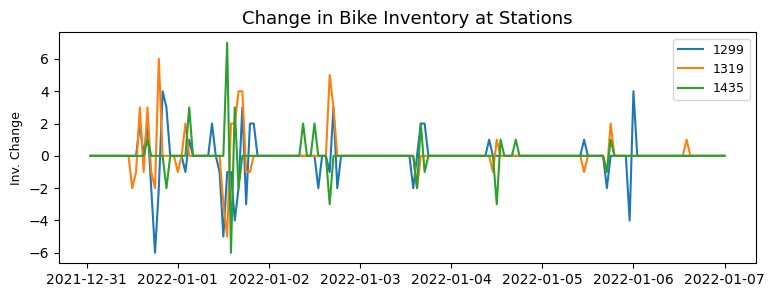

In [152]:
first = se1299_var[:168]
plt.figure(figsize=(9,3))

plt.plot(first["bike_diff"])
plt.plot(first["bike_diff_1319"])
plt.plot(first["bike_diff_1435"])

plt.legend(('1299', '1319', '1435'), fontsize=9)

plt.title('Change in Bike Inventory at Stations', fontsize=13)
plt.ylabel('Inv. Change', fontsize=9)

### Statistical Tests

adfuller test

In [81]:
from statsmodels.tsa.stattools import adfuller
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [118]:
print("prec_lag:")
perform_adf_test(se1299_var.prec_lag)
print("1319:")
perform_adf_test(se1299_var.bike_diff_1319)
print("1435:")
perform_adf_test(se1299_var.bike_diff_1435)
print(" ")

prec_lag:
ADF Statistic: -19.410479
p-value: 0.000000
1319:
ADF Statistic: -39.599676
p-value: 0.000000
1435:
ADF Statistic: -35.840747
p-value: 0.000000
 


Granger causality test

In [119]:
from statsmodels.tsa.stattools import grangercausalitytests

max_lags = 8

for i in range(len(se1299_var.columns)-1):
    results = grangercausalitytests(se1299_var[['bike_diff',se1299_var.columns[i+1]]], max_lags, verbose=False)
    p_values=[round(results[i+1][0]['ssr_ftest'][1],3) for i in range(max_lags)]
    print('Variable - {}: P_values - {}'.format(se1299_var.columns[i+1], p_values))

Variable - prec_lag: P_values - [0.531, 0.613, 0.605, 0.68, 0.7, 0.801, 0.854, 0.892]
Variable - bike_diff_1319: P_values - [0.0, 0.0, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0]
Variable - bike_diff_1435: P_values - [0.006, 0.0, 0.0, 0.0, 0.0, 0.001, 0.002, 0.001]


In [126]:
var_input = se1299_var.drop(columns=["prec_lag"])

In [194]:
var_input.to_csv("VAR_inputs.csv")

### Create Training Data

In [223]:
train_data = var_input[-len(var_input):-168]
test_data = var_input[-168:]

In [224]:
model = VAR(train_data, freq = "1H")

In [225]:
model.select_order(8).summary()

,AIC,BIC,FPE,HQIC
0,2.494,2.500,12.11,2.496
1,2.347,2.367,10.45,2.354
2,2.308,2.345*,10.06,2.321
3,2.294,2.346,9.917,2.313
4,2.285,2.353,9.829,2.309*
5,2.285*,2.368,9.824*,2.314
6,2.285,2.384,9.829,2.321
7,2.286,2.400,9.836,2.327
8,2.285,2.415,9.830,2.332


In [226]:
results = model.fit(5)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 05, Feb, 2023
Time:                     15:28:33
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    2.36540
Nobs:                     3570.00    HQIC:                   2.31193
Log likelihood:          -19222.8    FPE:                    9.79927
AIC:                      2.28231    Det(Omega_mle):         9.66868
--------------------------------------------------------------------
Results for equation bike_diff
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.076193         0.031101            2.450           0.014
L1.bike_diff             -0.250352         0.016810          -14.894           0.000
L1.bike_diff_1319        -0.064398      

Results for next 24 hours

In [229]:
lag = results.k_ar
predictions_24 = results.forecast(train_data.values[-lag:], steps=24)
predictions_24 = pd.Series(predictions_24[:,0], index=test_data[0:24].index)
residuals = test_data.bike_diff - predictions_24
print('Root Mean Squared Error (24hrs):', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error (24hrs): 3.307341021511492


Text(0, 0.5, 'Inv. Change')

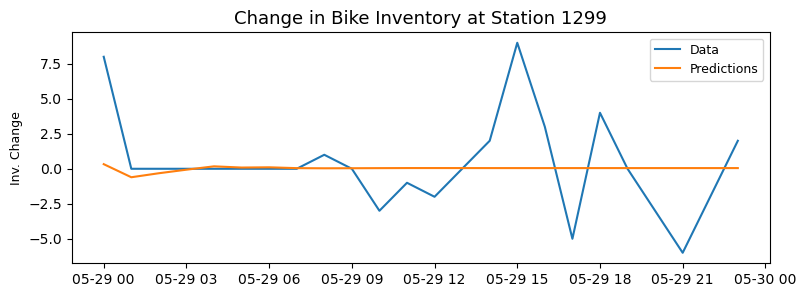

In [230]:
plt.figure(figsize=(9,3))
plt.plot(test_data[0:24]["bike_diff"])
plt.plot(predictions_24)
plt.legend(('Data', 'Predictions'), fontsize=9)
plt.title('Change in Bike Inventory at Station 1299', fontsize=13)
plt.ylabel('Inv. Change', fontsize=9)

Rolling Predictions

In [297]:
lag = 5

rolling_predictions = test_data[0:48]
preds = []

for train_end in rolling_predictions.index:
    model = VAR(var_input[:train_end], freq = "1H")
    y = var_input[train_end-timedelta(hours=lag):train_end].values
    prediction = model.fit(lag).forecast(y,steps=1)
    preds.append(prediction[0][0])

rolling_predictions["preds"] = preds

In [298]:
roll_residuals = rolling_predictions.bike_diff - rolling_predictions.preds
print('Root Mean Squared Error (rolling):', np.sqrt(np.mean(roll_residuals**2)))

Root Mean Squared Error (rolling): 3.835837608470916


Text(0, 0.5, 'Production')

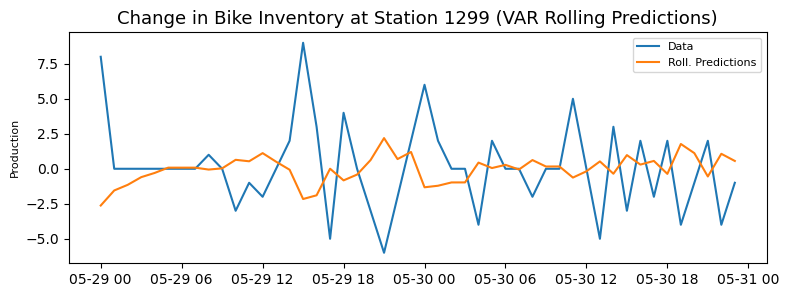

In [299]:
plt.figure(figsize=(9,3))

plt.plot(rolling_predictions.bike_diff)
plt.plot(rolling_predictions.preds)

plt.legend(('Data', 'Roll. Predictions'), fontsize=8)

plt.title('Change in Bike Inventory at Station 1299 (VAR Rolling Predictions)', fontsize=13)
plt.ylabel('Production', fontsize=8)

### VarMax

In [195]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [196]:
var_input = pd.read_csv("VAR_inputs.csv")

var_input['start_time_hour'] = pd.to_datetime(var_input['start_time_hour'], format="%Y-%m-%d %H:%M:%S")
var_input = var_input.set_index('start_time_hour') 

In [211]:
var_input['bike_diff'] = var_input['bike_diff'].astype(float)
var_input['bike_diff_1319'] = var_input['bike_diff_1319'].astype(float)
var_input['bike_diff_1435'] = var_input['bike_diff_1435'].astype(float)

In [212]:
train_data = var_input[-len(var_input):-168]
test_data = var_input[-168:]

In [214]:
model = VARMAX(train_data, order=(4, 3))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                           Statespace Model Results                                          
Dep. Variable:     ['bike_diff', 'bike_diff_1319', 'bike_diff_1435']   No. Observations:                 3575
Model:                                                    VARMA(4,3)   Log Likelihood              -19204.224
                                                         + intercept   AIC                          38552.449
Date:                                               Sun, 05 Feb 2023   BIC                          38997.533
Time:                                                       04:39:44   HQIC                         38711.123
Sample:                                                   12-31-2021                                         
                                                        - 05-28-2022                                         
Covariance Type:                                                 opg                                         
Ljung-Box 

In [216]:
predictions = model_fit.forecast(len(test_data))

In [218]:
predictions = (model_fit.forecast(len(test_data)))["bike_diff"]
residuals = test_data.bike_diff - predictions
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2.627613805634307


Text(0, 0.5, 'Inv. Change')

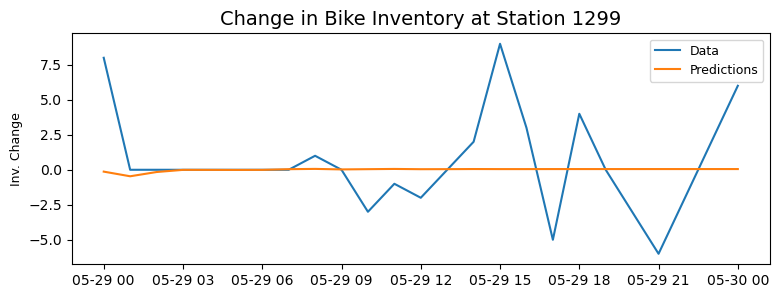

In [222]:
plt.figure(figsize=(9,3))

plt.plot(test_data[0:25]["bike_diff"])
plt.plot(predictions[0:25])

plt.legend(('Data', 'Predictions'), fontsize=9)

plt.title('Change in Bike Inventory at Station 1299', fontsize=14)
plt.ylabel('Inv. Change', fontsize=9)